#数据挖掘互评作业四：离群点分析与异常检测#
##数据集：wine##

##1、导入并展示数据## 

首先以一个文件为例导入并展示文件
数据集说明：
该数据集共包括17列，其中original.label为原始数据的类标签，为红酒的质量；
ground.truth取值为nominal表示正常点，anomaly表示异常点;
后11列为分类预测所使用的特征

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score,auc,roc_curve
from sklearn.model_selection import train_test_split 
import os
import warnings
warnings.filterwarnings("ignore")

In [85]:
#导入数据
data = pd.read_csv('./wine/benchmarks/wine_benchmark_0001.csv')
print('数据行数:'+str(data.shape[0]))
print('数据列数:'+str(data.shape[1]))
print("每个变量数据类型:")
print(data.dtypes)
print("数据前五行:")
data.head()

数据行数:2351
数据列数:17
每个变量数据类型:
point.id                 object
motherset                object
origin                   object
original.label            int64
diff.score              float64
ground.truth             object
fixed.acidity           float64
volatile.acidity        float64
citric.acid             float64
residual.sugar          float64
chlorides               float64
free.sulfur.dioxide     float64
total.sulfur.dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object
数据前五行:


,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_1344,wine,regression,6,0.472828,nominal,-0.474615,-0.544630,-0.059409,1.462180,0.084666,1.209882,1.154517,1.235002,1.812950,-0.411733,-0.580023
1,wine_point_1245,wine,regression,5,0.383027,anomaly,-0.628884,-0.483890,-0.678741,-0.072142,-0.543303,-0.423976,0.269903,-0.098922,0.444682,-1.419758,-0.328496
2,wine_point_2224,wine,regression,6,0.481863,nominal,-0.243211,-0.666110,0.078220,1.546252,-0.000967,0.759163,0.942209,1.101609,1.253204,-0.747741,-0.580023
3,wine_point_1930,wine,regression,5,0.181031,anomaly,1.222348,0.002029,0.078220,0.894691,-0.571847,0.871842,0.995286,0.634736,-0.861392,-0.882144,-0.244653
4,wine_point_5546,wine,regression,4,0.398576,anomaly,0.836674,3.069393,-2.123849,-0.681666,0.398650,-1.438095,-1.800093,0.668084,0.631264,0.327485,0.426087


数据集中正常点和异常点的样本数：

In [86]:
data['ground.truth'].value_counts()

nominal    1325
anomaly    1026
Name: ground.truth, dtype: int64

提取original.label，fixed.acidity，volatile.acidity，citric.acid，residual.sugar，chlorides，free.sulfur.dioxide，total.sulfur.dioxide，density，pH，sulphates，alcohol这十二个特征后续的的离群点分类预测

In [87]:
x = data[['original.label','fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']]
x.head()

,original.label,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,6,-0.474615,-0.544630,-0.059409,1.462180,0.084666,1.209882,1.154517,1.235002,1.812950,-0.411733,-0.580023
1,5,-0.628884,-0.483890,-0.678741,-0.072142,-0.543303,-0.423976,0.269903,-0.098922,0.444682,-1.419758,-0.328496
2,6,-0.243211,-0.666110,0.078220,1.546252,-0.000967,0.759163,0.942209,1.101609,1.253204,-0.747741,-0.580023
3,5,1.222348,0.002029,0.078220,0.894691,-0.571847,0.871842,0.995286,0.634736,-0.861392,-0.882144,-0.244653
4,4,0.836674,3.069393,-2.123849,-0.681666,0.398650,-1.438095,-1.800093,0.668084,0.631264,0.327485,0.426087


将ground.truth这一列划分为0和1,0代表正常点，1代表异常点，作为类标签

In [21]:
y = data[['ground.truth']]
y['ground.truth']=np.where(y['ground.truth']=='anomaly',1,0)
y = y['ground.truth'].values

##2、离群点预测##
现在读入全部benchmark数据文件，使用Cluster-based Local Outiler Factor、Feature Bagging、
Histogram-base Outlier Detection(HBOS)、Isolation Forest、KNN、Average KNN这六种分类器进行离群点分类预测，
并采用auc取平均作为评估指标

In [2]:
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [5]:
classifiers = ["Cluster-based Local Outiler Factor (CBLOF)","Feature Bagging","Histogram-base Outlier Detection(HBOS)",\
              "Isolation Forest","KNN","Average KNN"]
auc_score = {}
for clf_name in classifiers:
    auc_score[clf_name] = []

In [6]:
##输入全部wine-benchmarks数据集进行离群点预测
path_in = './wine/benchmarks/'
files = os.listdir(path_in)
for file in files:
    filename = path_in+file
    data = pd.read_csv(filename) ##读入数据
    ##提取特征x和类标签y
    x = data[['original.label','fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']]
    y = data[['ground.truth']]
    y['ground.truth']=np.where(y['ground.truth']=='anomaly',1,0)
    y = y['ground.truth'].values
    ##划分测试集和训练集
    x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)
        
    ##定义分类器
    outliers_fraction = data['ground.truth'].value_counts()['anomaly'] / len(data)  ##异常点比例
    classifiers = {
        "Cluster-based Local Outiler Factor (CBLOF)": CBLOF(contamination = outliers_fraction,check_estimator=False),
        "Feature Bagging" : FeatureBagging(LOF(n_neighbors=50),contamination=outliers_fraction,check_estimator=False),
        "Histogram-base Outlier Detection(HBOS)" : HBOS(contamination=outliers_fraction),
        "Isolation Forest" :IForest(contamination=outliers_fraction),
        "KNN" : KNN(contamination=outliers_fraction),
        "Average KNN" :KNN(method='mean',contamination=outliers_fraction)
    }
    ##初始化auc
    ##分类预测
    for i ,(clf_name,clf) in enumerate(classifiers.items()):
        clf.fit(x_train)
        # 预测离群得分
        scores_pred = clf.decision_function(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, scores_pred, pos_label=1)
        auc_score[clf_name].append(auc(fpr,tpr))

In [27]:
##计算auc平均值
result = {}
for clf in auc_score.keys():
    sum = 0
    for item in auc_score[clf]:
        sum += item
    sum /= len(auc_score[clf])
    result[clf] = sum

##3、结果可视化##

In [28]:
df = pd.DataFrame.from_dict(result, orient='index',columns=['auc'])
df = df.reset_index().rename(columns = {'index':'id'})
df

,id,auc
0,Cluster-based Local Outiler Factor (CBLOF),0.723504
1,Feature Bagging,0.813603
2,Histogram-base Outlier Detection(HBOS),0.571192
3,Isolation Forest,0.802986
4,KNN,0.777335
5,Average KNN,0.804084


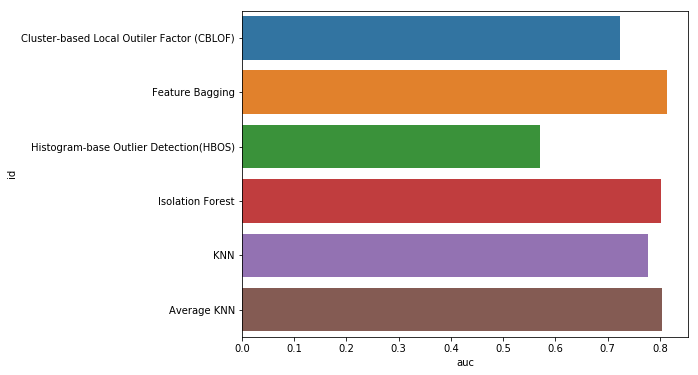

In [29]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(y=df.id,x='auc',data=df)

##4、结果分析##
通过输出的结果和可视化分析可以看出，六种分类器中Feature Bagging的预测效果最好，auc达到了0.81，所使用的Feature Bagging近邻数设置为50；
Average KNN和Isolation Forest的效果接近，略低于Feature Bagging；
KNN和Cluster-based Local Outiler Factor (CBLOF)的auc得分都在0.7-0.8之间；
而Histogram-base Outlier Detection的预测效果最差，auc得分仅为0.57